# Main Code

## 0. Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/object_image'

/content/drive/MyDrive/object_image


In [3]:
!ls

 data   data.tar.gz  'Main Code.ipynb'


In [ ]:
#!tar -zcvf data.tar.gz data  

In [ ]:
#!tar -xzf data.tar.gz

## 1. Data Load

In [4]:
from glob import glob
import os
import PIL
PIL.Image

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') # 경고 메세지 숨김
os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU 할당

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers, models
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### 함수 및 상수 정의

In [5]:
# Data Load fuction Def
def load_CIFAR10(path):
    
    path = path
    images = []
    labels = []
    for filename in glob(path +"*"):
        for img in glob(filename + "/*.jpg"):
            an_img = PIL.Image.open(img) #read img
            img_array = np.array(an_img) #img to array
            images.append(img_array) #append array to training_images
            label = filename.split('/')[2] #get label
            labels.append(label) #append label
    images = np.array(images)
    labels = np.array(labels)

    le = LabelEncoder()
    labels= le.fit_transform(labels)
    labels = labels.reshape(-1,1)
    
    return images, labels, le

#create test dataset
def load_test(path):
    test_images = []
    test_idx = []

    flist = sorted(glob(path + '*.jpg'))

    for filename in flist:
        an_img = PIL.Image.open(filename) #read img
        img_array = np.array(an_img) #img to array
        test_images.append(img_array) #append array to training_images 
        
        label = filename.split('/')[2] #get id 
        test_idx.append(label) #append id
        
    test_images = np.array(test_images)

    print(test_images.shape)
    print(test_idx[0:5])
    return test_images

# Define image's format
class Default:
    imgR     = 32
    imgC     = 32
    channel  = 3
    imgCount = 5000
    
# Visualize Image
def plot_images(nRow,nCol,img):
    fig = plt.figure()
    fig,ax = plt.subplots(nRow,nCol,figsize=(nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i,j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

In [6]:
path = 'data/train/'
class_labels = { 0:'airplane', 1:'automobile',2:'bird', 3:'cat', 4:'deer', 
                5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

### 데이터 불러오기

In [7]:
training_images, training_labels, le = load_CIFAR10(path=path)

In [8]:
test_images = load_test('data/test/')

(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']


## 2. EDA

In [9]:
print("train 이미지 크기:", training_images.shape)
print("train 라벨 크기:", training_labels.shape)
print('클래스 값:',np.unique(training_labels))

train 이미지 크기: (50000, 32, 32, 3)
train 라벨 크기: (50000, 1)
클래스 값: [0 1 2 3 4 5 6 7 8 9]


[[0 0 0 0 0 0 0 0 0 0]]


<Figure size 432x288 with 0 Axes>

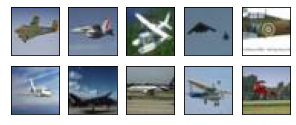

In [10]:
plot_images(2,5,training_images[:10])
print(training_labels[:10].reshape(1,-1))

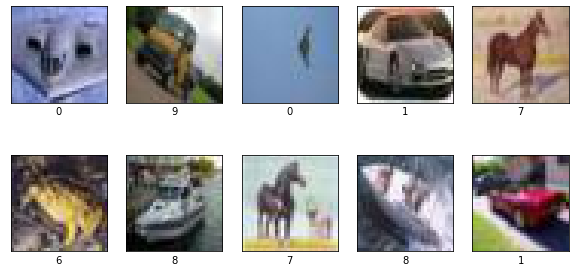

In [11]:
plt.figure(figsize=[10,5])
for i in range(10):
    import random
    num = random.randint(0,50000)
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(training_labels[num][0])
    plt.imshow(training_images[num])
plt.show()

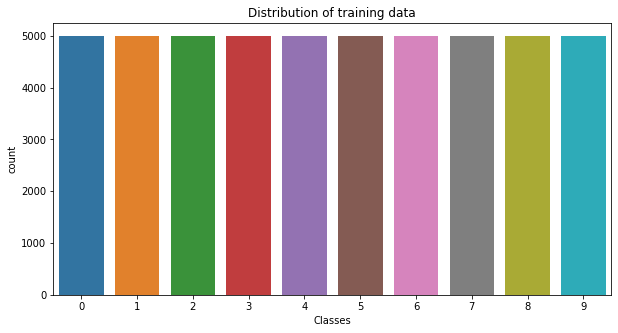

In [12]:
plt.figure(figsize=[10,5])
sns.countplot(training_labels.ravel())
plt.title('Distribution of training data')
plt.xlabel('Classes')
plt.show()

## 3. Data Prepare & Preprocessing

In [13]:
idx = np.arange(training_images.shape[0])
np.random.shuffle(idx)
training_images = training_images[idx]
training_labels = training_labels[idx]
idx

array([10935, 21495,  7825, ..., 48146, 35577, 45294])

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(training_images, training_labels, test_size=0.2, random_state=42)
X_test = test_images

In [15]:
print('X_train 크기:',X_train.shape)
print('X_valid 크기:',X_valid.shape)
print('X_test 크기:',X_test.shape)

X_train 크기: (40000, 32, 32, 3)
X_valid 크기: (10000, 32, 32, 3)
X_test 크기: (10000, 32, 32, 3)


In [16]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

## 4. CNN Model Design

In [54]:
# CNN 인공신경망 정의
def create_model():
    model = Sequential()

    model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, kernel_regularizer='l2', activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [55]:
# 가중치 정보 저장 경로
checkpoint_dir = path+'Training_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 5번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
model = create_model()
# Checking the model summary
model.summary()

In [ ]:
# !rm -rf Training_checkpoint/ # 가중치 저장 파일 전체 삭제

In [57]:
history = model.fit(X_train, y_train, batch_size=128, epochs=500,
                    callbacks=[early_stopping, cp],
                    validation_data = (X_valid,y_valid), verbose=0)


Epoch 1: val_loss improved from inf to 3.35355, saving model to data/train/Training_checkpoint/cp-0001-3.35.ckpt

Epoch 2: val_loss improved from 3.35355 to 1.82368, saving model to data/train/Training_checkpoint/cp-0002-1.82.ckpt

Epoch 3: val_loss improved from 1.82368 to 1.56776, saving model to data/train/Training_checkpoint/cp-0003-1.57.ckpt

Epoch 4: val_loss improved from 1.56776 to 0.88939, saving model to data/train/Training_checkpoint/cp-0004-0.89.ckpt

Epoch 5: val_loss did not improve from 0.88939

Epoch 6: val_loss improved from 0.88939 to 0.81740, saving model to data/train/Training_checkpoint/cp-0006-0.82.ckpt

Epoch 7: val_loss did not improve from 0.81740

Epoch 8: val_loss did not improve from 0.81740

Epoch 9: val_loss did not improve from 0.81740

Epoch 10: val_loss improved from 0.81740 to 0.76191, saving model to data/train/Training_checkpoint/cp-0010-0.76.ckpt

Epoch 11: val_loss did not improve from 0.76191

Epoch 12: val_loss improved from 0.76191 to 0.72682, 

## 5. Learning Curve

Text(0.5, 1.0, 'Loss Curves')

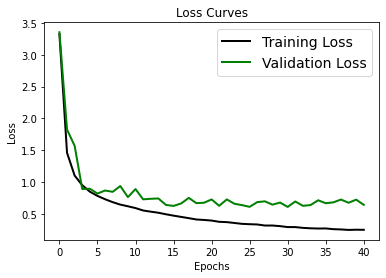

In [58]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

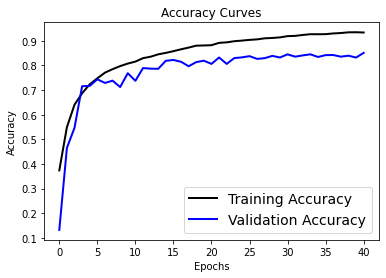

In [59]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

## 6. Saving Model

In [ ]:
# 모델 저장
model.save('save/savedModel/')

In [ ]:
# history 파일로 저장
history_df = pd.DataFrame(history.history)

with open('save/history.csv', mode='w') as hist_file:
    history_df.to_csv(hist_file)

## 7. Prediction Performance

In [60]:
pred_proba = model.predict(X_test) 

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)

pred_class = le.inverse_transform(pred_class)
pred_class[0:5]

array(['horse', 'airplane', 'airplane', 'cat', 'airplane'], dtype='<U10')

In [61]:
sample_submission = pd.read_csv("./data/sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("submit2.csv",index=False)

In [62]:
sample_submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,airplane
2,0002.jpg,airplane
3,0003.jpg,cat
4,0004.jpg,airplane
